In [40]:
import math, copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.metrics import PrecisionRecallDisplay, f1_score, mean_absolute_error, precision_recall_curve, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay, roc_curve


my_ID = 400132290
np.random.seed(my_ID)
np.set_printoptions(precision=2)# reduced display precision on numpy arrays

In [41]:
data = load_breast_cancer()
x_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=my_ID)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

print(f"X Shape: {x_train.shape}, X Type:{type(x_train)})")
#print(x_train)
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")
#print(y_train)

X Shape: (455, 30), X Type:<class 'numpy.ndarray'>)
y Shape: (455,), y Type:<class 'numpy.ndarray'>)


**to do**
- ~~my version of Batch and SGD~~
- ~~compute missclassification rate~~
- ~~F1 ?~~
- ~~plot precision/recall PR curve and ROC curve~~
- something about B???

In [42]:
# without matrix multiplication
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """

    g = 1/(1+np.exp(-z))
   
    return g

def compute_cost_logistic(X, y, w, b):
    """
    Computes cost

    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """

    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)
             
    cost = cost / m
    return cost

def compute_gradient_logistic(X, y, w, b): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))                           #(n,)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar
        
    return dj_db, dj_dw 

def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_logistic(X, y, w, b) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w, b, J_history         #return final w,b and J history for graphing

def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model

    Returns:
      p : (ndarray (m,)) The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
    J_history = []
   
    # Loop over each example
    for i in range(m):   
        f_wb_i = sigmoid(np.dot(X[i],w) +b)
        
        if f_wb_i >= 0.5:
            p[i] = 1
        else:
            p[i] = 0
        
    return p

In [43]:
# SGD
def compute_gradient_logistic_SGD(X, y, w, b): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b. 
    """
    n = X.shape[0]
    dj_dw = np.zeros((n,))                           #(n,)
    dj_db = 0.


    f_wb_i = sigmoid(np.dot(X,w) + b)          #(n,)(n,)=scalar
    err_i  = f_wb_i  - y                       #scalar
    for j in range(n):
        dj_dw[j] = dj_dw[j] + err_i * X[j]      #scalar
    dj_db = dj_db + err_i
        
    return dj_db, dj_dw  

def gradient_descent_SGD(X, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    num_rows = X.shape[0]
    for i in range(num_iters):
        # generate random index and index the array to retrieve a roll
        random_index = np.random.choice(num_rows)
        
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic_SGD(X[random_index], y[random_index], w, b)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_logistic(X, y, w, b) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w, b, J_history         #return final w,b and J history for graphing

# X_train = np.array([[2104, 5, 1, 45], [1416, 3, 2, 40], [852, 2, 1, 35]])
# y_train = np.array([460, 232, 178])
# b_init = 785.1811367994083
# w_init = np.array([ 0.39133535, 18.75376741, -53.36032453, -26.42131618])
#Compute and display gradient 

# tmp_dj_db, tmp_dj_dw = compute_gradient_logistic_SGD(X_train[i], y_train[i], w_init, b_init)
# print(f'dj_db at initial w,b: {tmp_dj_db}')
# print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')


In [44]:
# w_tmp  = np.zeros_like(x_train[0])
# b_tmp  = 0.
# alph = 0.1
# iters = 100000
# w_out, b_out, _ = gradient_descent_SGD(x_train, y_train, w_tmp, b_tmp, alph, iters)

# p_train = predict(x_train, w_out, b_out)
# p_test = predict(x_test, w_out, b_out)
# print(f'Output of predict: shape {p_test.shape}')
# print('Train Accuracy: %f'%(np.mean(p_train == y_train) * 100))
# print('Test Accuracy: %f'%(np.mean(p_test == y_test) * 100))
# print(f"model parameters (SGD): w: {w_out}, b:{b_out}")

In [45]:
# w_tmp  = np.zeros_like(x_train[0])
# b_tmp  = 0.
# alph = 0.1
# iters = 100000

# w_out, b_out, _ = gradient_descent(x_train, y_train, w_tmp, b_tmp, alph, iters)

# p_train = predict(x_train, w_out, b_out)
# p_test = predict(x_test, w_out, b_out)
# print(f'Output of predict: shape {p_test.shape}')
# print('Train Accuracy: %f'%(np.mean(p_train == y_train) * 100))
# print('Test Accuracy: %f'%(np.mean(p_test == y_test) * 100))
# print(f"model parameters (batch): w: {w_out}, b:{b_out}")

In [46]:
# matrix implementation
def train_logistic_regression(x_train, y_train, a):
    """
    Perform batch gradient descent to train the logistic regression model

    :param x_train: the training input
    :param y_train: the true values
    :param a: the learning rate
    :return: the weights and bias for the model
    """
    # initialize weights and bias to zero
    weights = np.zeros(x_train.shape[1])
    i = 0
    J_history = []
    num_itiers = 10000
    while (i < num_itiers):
        # calculate predictions
        preds = sigmoid(x_train @ weights)

        # update the params
        grad = (1 / x_train.shape[0]) * x_train.T @ (preds - y_train)

        weights -= grad * a

        # calculate the loss
        loss = y_train * np.logaddexp(0, -sigmoid(x_train @ weights)) + (1 - y_train) * np.logaddexp(0, sigmoid(x_train @ weights))

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( np.sum(loss[1:])/ x_train.shape[0])

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_itiers / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        # if i > 2:
        #     if J_history[-2] - J_history[-1] < 0.00004:
        #         break
        i += 1

    return weights, J_history

def train_logistic_regression_SGD(x_train, y_train, a):
    """
    Perform  to train the logistic regression model

    :param x_train: the training input
    :param y_train: the true values
    :param a: the learning rate
    :return: the weights and bias for the model
    """
    # initialize weights and bias to zero
    weights = np.zeros(x_train.shape[1])
    i = 0
    num_rows = x_train.shape[0]
    J_history = []
    num_itiers = 10000
    while (i < num_itiers):
        # randomly p
        random_index = np.random.choice(num_rows)
        x_train_SGD = x_train[random_index]
        # calculate predictions
        preds = sigmoid(x_train_SGD @ weights)

        # update the params
        grad = x_train_SGD.T * (preds - y_train[random_index])

        weights -= grad * a

        # calculate the loss
        loss = y_train * np.logaddexp(0, -sigmoid(x_train @ weights)) + (1 - y_train) * np.logaddexp(0, sigmoid(x_train @ weights))

        # Save cost J at each iteration
        if i<10000:      # prevent resource exhaustion 
            J_history.append( np.sum(loss[1:])/ x_train.shape[0])

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_itiers / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        # if i > 2:
        #     if J_history[-2] - J_history[-1] < 0.00004:
        #         break
        i += 1

    return weights, J_history

def predict_log_reg(x_test, weights, threshold=0.5):
    preds = sigmoid(x_test @ weights)

    # split classification at threshold
    pred_class = [1 if i > threshold else 0 for i in preds]

    return np.array(pred_class)

def calc_pr_curve(y_test, z):
    precisions, recalls = [], []

    sorted_probs = sorted(z)

    # calculate the precision and recall score for each threshold
    for thresh in sorted_probs:
        precisions.append(precision_score(y_test, z > thresh, zero_division=1))
        recalls.append(recall_score(y_test, z > thresh))

    return np.array(precisions), np.array(recalls)



Iteration    0: Cost 0.6207673075176638   
Iteration 1000: Cost 0.47659422071305263   
Iteration 2000: Cost 0.47404357842393596   
Iteration 3000: Cost 0.4729541893198515   
Iteration 4000: Cost 0.47232631344431697   
Iteration 5000: Cost 0.4719058669018744   
Iteration 6000: Cost 0.47159974048560716   
Iteration 7000: Cost 0.4713644135726444   
Iteration 8000: Cost 0.471176245335267   
Iteration 9000: Cost 0.47102117035344854   
batch
log reg [-0.47 -0.46 -0.33 -0.45 -0.51 -0.05  1.33 -1.34 -1.64  0.44  0.3  -2.
  0.26 -1.18 -1.48 -0.53  0.87  0.46 -0.46  0.77  0.77 -1.35 -2.11 -1.04
 -1.33 -1.09  0.3  -1.83 -1.03 -1.58 -0.32] 

Test Accuracy: 96.491228
Missclassification rate: 3.508772
F1 score: 0.9746835443037976
Iteration    0: Cost 0.6307799892124186   
Iteration 1000: Cost 0.47837416748629835   
Iteration 2000: Cost 0.4730286817592097   
Iteration 3000: Cost 0.4749155461015837   
Iteration 4000: Cost 0.4726492879266099   
Iteration 5000: Cost 0.47174433897396084   
Iteration 6000

Text(0, 0.5, 'true postive')

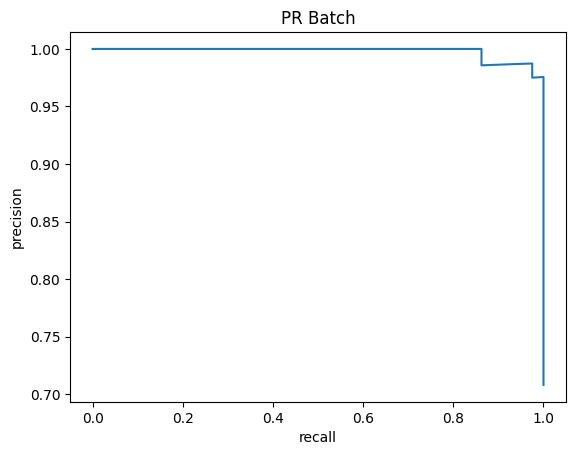

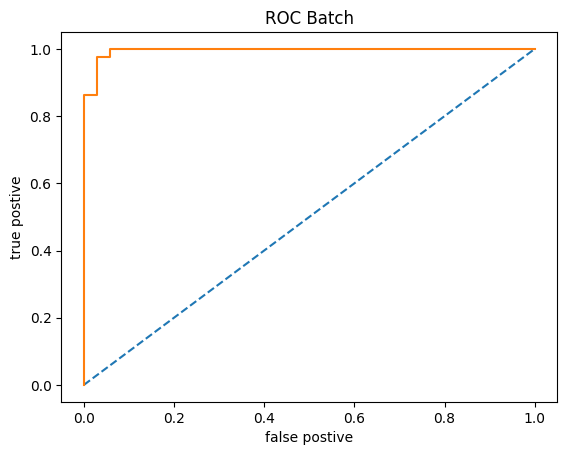

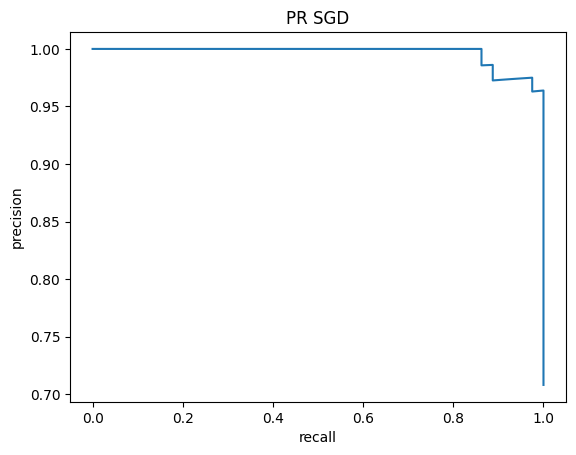

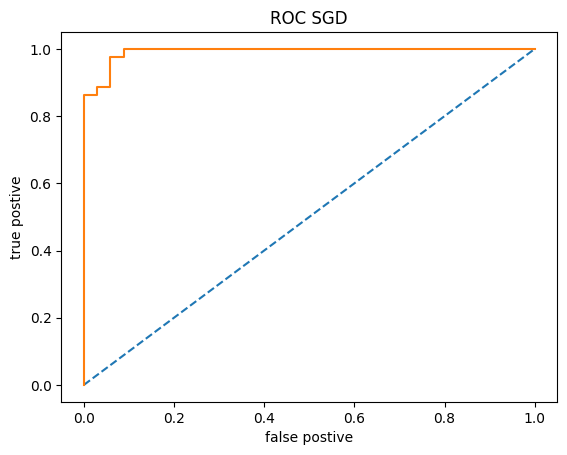

In [47]:
# self 
# initialize data
x_train_mat = np.c_[np.ones(x_train.shape[0]), x_train]
x_test_mat = np.c_[np.ones(x_test.shape[0]), x_test]

# Batch
# calc parameter w
w_batch, J_history_batch = train_logistic_regression(x_train_mat, y_train, 0.1)
print("batch")
print(f"log reg {w_batch}","\n")

# find Accuracy, MC rate, F1 score
p_test = predict_log_reg(x_test_mat, w_batch)
print('Test Accuracy: %f'%(np.mean(p_test == y_test) * 100))
print('Missclassification rate: %f'%(np.mean(p_test != y_test) * 100))
f1 = f1_score(y_test, p_test)
print(f"F1 score: {f1}")


# plot PR curve
z = sigmoid(x_test_mat @ w_batch)
precision, recall = calc_pr_curve(y_test, z)
# disp = PrecisionRecallDisplay(precision, recall)
# disp.plot()
# disp.ax_.set_title("PR Batch")
plt.figure()
plt.plot(recall,precision)
plt.title("PR Batch")
plt.xlabel("recall")
plt.ylabel("precision")

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, z)
plt.figure()
plt.plot([0,1],[0,1], '--')
plt.plot(fpr,tpr)
plt.title("ROC Batch")
plt.xlabel("false postive")
plt.ylabel("true postive")

# SGD
# calc parameter w
w_SGD, J_history_SGD = train_logistic_regression_SGD(x_train_mat, y_train, 0.1)
print("SGD")
print(f"log reg SGD {w_SGD}","\n")

# find Accuracy, MC rate, F1 score
p_test = predict_log_reg(x_test_mat, w_SGD)
print('Test Accuracy: %f'%(np.mean(p_test == y_test) * 100))
print('Missclassification rate: %f'%(np.mean(p_test != y_test) * 100))
f1 = f1_score(y_test, p_test)
print(f"F1 score: {f1}")

# plot PR curve
z = sigmoid(x_test_mat @ w_SGD)
precision, recall = calc_pr_curve(y_test, z)
# disp = PrecisionRecallDisplay(precision, recall)
# disp.plot()
# disp.ax_.set_title("PR SGD")
plt.figure()
plt.plot(recall,precision)
plt.title("PR SGD")
plt.xlabel("recall")
plt.ylabel("precision")

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, z)
plt.figure()
plt.plot([0,1],[0,1], '--')
plt.plot(fpr,tpr)
plt.title("ROC SGD")
plt.xlabel("false postive")
plt.ylabel("true postive")

In [48]:
B = [0.1 + 0.1 * i for i in range(9)]
for i in B:
    p_test = predict_log_reg(x_test_mat, w_batch, threshold=i)
    print('Test Accuracy B=%.1f: %f'%(i, np.mean(p_test == y_test) * 100))

Test Accuracy B=0.1: 97.368421
Test Accuracy B=0.2: 97.368421
Test Accuracy B=0.3: 98.245614
Test Accuracy B=0.4: 96.491228
Test Accuracy B=0.5: 96.491228
Test Accuracy B=0.6: 96.491228
Test Accuracy B=0.7: 96.491228
Test Accuracy B=0.8: 96.491228
Test Accuracy B=0.9: 91.228070


In [49]:
w_batch, J_history_batch_small = train_logistic_regression(x_train_mat, y_train, 1e-5)
w_SGD, J_history_SGD_small = train_logistic_regression_SGD(x_train_mat, y_train, 1e-5)
w_batch, J_history_batch_zero = train_logistic_regression(x_train_mat, y_train, 0)
w_SGD, J_history_SGD_zero = train_logistic_regression_SGD(x_train_mat, y_train, 0)

Iteration    0: Cost 0.6675354731515012   
Iteration 1000: Cost 0.662560532667297   
Iteration 2000: Cost 0.6577940579882247   
Iteration 3000: Cost 0.6532368424526833   
Iteration 4000: Cost 0.6488865277716845   
Iteration 5000: Cost 0.6447382790844728   
Iteration 6000: Cost 0.6407854398894309   
Iteration 7000: Cost 0.6370201132922807   
Iteration 8000: Cost 0.6334336446110935   
Iteration 9000: Cost 0.630017001399482   
Iteration    0: Cost 0.6675370190214283   
Iteration 1000: Cost 0.6626913014822905   
Iteration 2000: Cost 0.6579950856730168   
Iteration 3000: Cost 0.6534709427565466   
Iteration 4000: Cost 0.6490496817306951   
Iteration 5000: Cost 0.6447845627328619   
Iteration 6000: Cost 0.6408894136999935   
Iteration 7000: Cost 0.6371853100075493   
Iteration 8000: Cost 0.6335050674834295   
Iteration 9000: Cost 0.6300572683818065   
Iteration    0: Cost 0.6675405512478425   
Iteration 1000: Cost 0.6675405512478425   
Iteration 2000: Cost 0.6675405512478425   
Iteration 300

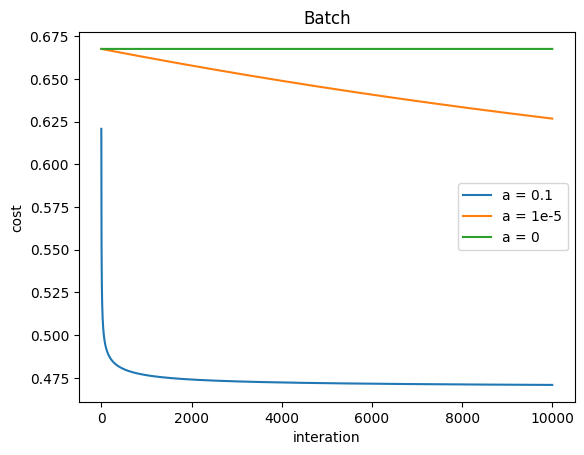

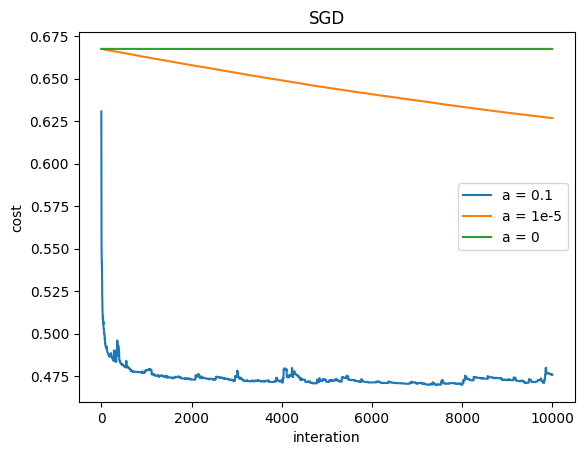

In [50]:
plt.figure()
plt.plot(J_history_batch, label="a = 0.1")
plt.plot(J_history_batch_small, label="a = 1e-5")
plt.plot(J_history_batch_zero, label="a = 0")
plt.title('Batch')
plt.xlabel('interation')
plt.ylabel('cost')
plt.legend()
plt.figure()
plt.plot(J_history_SGD, label="a = 0.1")
plt.plot(J_history_SGD_small, label="a = 1e-5")
plt.plot(J_history_SGD_zero, label="a = 0")
plt.title('SGD')
plt.xlabel('interation')
plt.ylabel('cost')
plt.legend()

Batch
number of iterations completed: [32]
model parameters (batch): w: [[-0.48 -0.46 -0.47 -0.5  -0.09  0.56 -0.9  -1.    0.17  0.31 -1.11  0.12
  -0.72 -0.87 -0.33  0.59  0.2  -0.24  0.49  0.48 -0.89 -1.28 -0.76 -0.87
  -0.75  0.08 -1.08 -0.71 -0.94 -0.21]], b:[-0.03]
The test error for the sklearn implementation is: 0.03508771929824561, the f1-score is: 0.9746835443037976
SGD
number of iterations completed: 15
model parameters (SGD): w: [[ -4.98   2.21  -5.19  -3.71  -3.8   10.69  -8.76 -11.48   2.89   2.56
  -12.49   3.77  -6.6  -12.09  -4.5   -0.24  15.85  -4.96   6.03   3.98
  -10.25 -17.57  -6.74  -9.83  -6.54  -2.73 -10.97  -6.06 -14.02  -2.41]], b:[-4.]
The test error for the sklearn implementation is: 0.02631578947368421, the f1-score is: 0.9811320754716981


Text(0, 0.5, 'true postive')

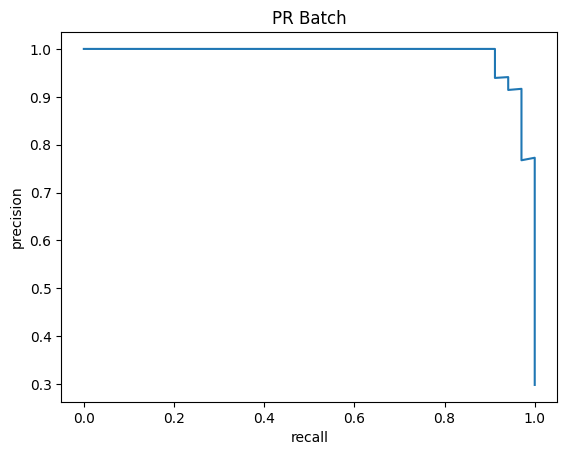

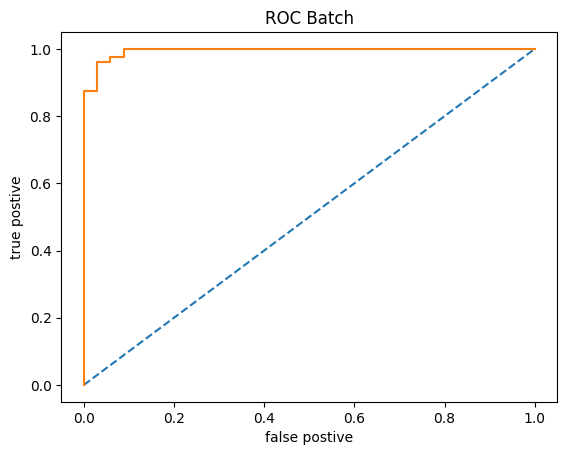

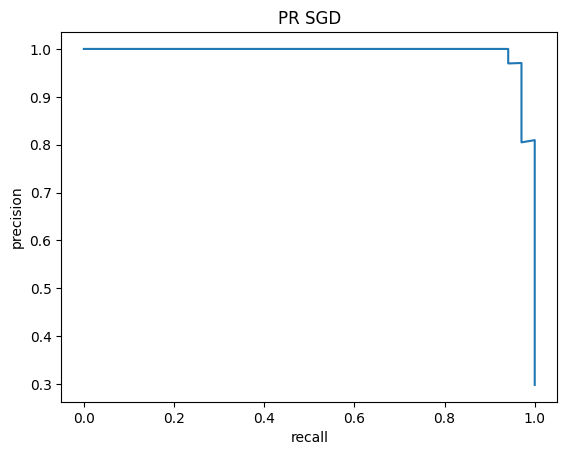

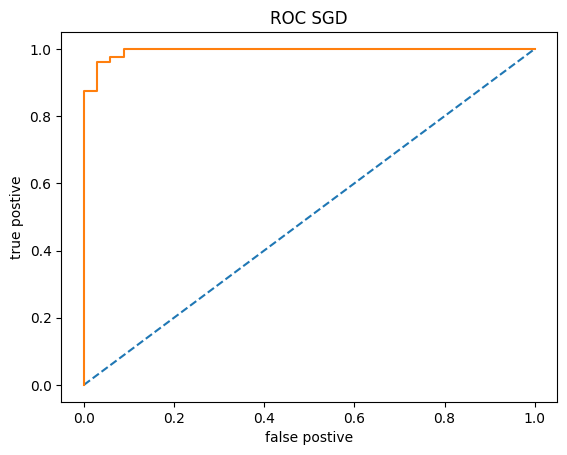

In [51]:
# sklearn
# batch
# calc parameter w and b
print("Batch")
log_reg_batch =LogisticRegression(random_state=my_ID)
log_reg_batch.fit(x_train, y_train)
print(f"number of iterations completed: {log_reg_batch.n_iter_}")
log_reg_batch_b = log_reg_batch.intercept_
log_reg_batch_w = log_reg_batch.coef_
print(f"model parameters (batch): w: {log_reg_batch_w}, b:{log_reg_batch_b}")

# calc error and F1 score
predictions_batch = log_reg_batch.predict(x_test)
best_misclass_rate = mean_absolute_error(y_test, predictions_batch)
f1_s = f1_score(y_test, predictions_batch)
print(f"The test error for the sklearn implementation is: {best_misclass_rate}, the f1-score is: {f1_s}")

# plot PR curve
probas_pred = log_reg_batch.predict_proba(x_test)[:,0]
precision, recall, _ = precision_recall_curve(y_test, probas_pred, pos_label=0)
plt.figure()
plt.plot(recall,precision)
plt.title("PR Batch")
plt.xlabel("recall")
plt.ylabel("precision")

# ROC curve
# B = ln((1-theta)/theta) where theta is the boundry
probas_pred = log_reg_batch.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probas_pred)
plt.figure()
plt.plot([0,1],[0,1], '--')
plt.plot(fpr,tpr)
plt.title("ROC Batch")
plt.xlabel("false postive")
plt.ylabel("true postive")

# SGD
# calc parameter w and b
print("SGD")
log_reg_SGD = SGDClassifier(random_state=my_ID,loss="log_loss")
log_reg_SGD.fit(x_train, y_train)
print(f"number of iterations completed: {log_reg_SGD.n_iter_}")
log_reg_SGD_b = log_reg_SGD.intercept_
log_reg_SGD_w = log_reg_SGD.coef_
print(f"model parameters (SGD): w: {log_reg_SGD_w}, b:{log_reg_SGD_b}")

# calc error and F1 score
predictions_SGD = log_reg_SGD.predict(x_test)
best_misclass_rate = mean_absolute_error(y_test, predictions_SGD)
f1_s = f1_score(y_test, predictions_SGD)
print(f"The test error for the sklearn implementation is: {best_misclass_rate}, the f1-score is: {f1_s}")

# plot PR curve
probas_pred = log_reg_SGD.predict_proba(x_test)[:, 0]
precision, recall, thresholds = precision_recall_curve(y_test, probas_pred, pos_label=0)
plt.figure()
plt.plot(recall,precision)
plt.title("PR SGD")
plt.xlabel("recall")
plt.ylabel("precision")

# ROC curve
# B = ln((1-theta)/theta) where theta is the boundry
probas_pred = log_reg_batch.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probas_pred)
plt.figure()
plt.plot([0,1],[0,1], '--')
plt.plot(fpr,tpr)
plt.title("ROC SGD")
plt.xlabel("false postive")
plt.ylabel("true postive")